# ML Models

## Imports

In [1]:
import xgboost
import json
import numpy as np
import pandas as pd
import lightgbm as lgb
import tensorflow as tf
import matplotlib.cm as cm
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline
from keras.utils import to_categorical
from tensorflow.keras.models import Model
from sklearn.naive_bayes import GaussianNB
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.layers import Dense, Dropout, Input, Multiply, Activation, BatchNormalization, Flatten

In [2]:
# set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## Load Datasets

In [3]:
# read json file into a df
df = pd.read_json('c:/Users/User/Desktop/DATA/01 Labeled CSI DATA/5th_try_labeled_csi_data.json')
print(df.head())

C:\Users\User\AppData\Local\Temp\ipykernel_1444\4233416732.py:2: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df = pd.read_json('c:/Users/User/Desktop/DATA/01 Labeled CSI DATA/5th_try_labeled_csi_data.json')


             datetime      cfo   snr  \
0 2024-05-29 09:04:00  25215.5  10.8   
1 2024-05-29 09:04:00  18145.7   6.4   
2 2024-05-29 09:04:00  28780.0   6.5   
3 2024-05-29 09:04:00  26879.3  10.2   
4 2024-05-29 09:04:00  22685.4   9.6   

                                                real  \
0  [-0.079, -0.111, -0.139, -0.138, -0.132, -0.13...   
1  [0.057, 0.041, 0, 0.014, 0.023, 0.068, 0.10200...   
2  [0.039, 0.018000000000000002, -0.002, 0.044, 0...   
3  [-0.068, -0.055, -0.028, -0.061, -0.096, -0.11...   
4  [-0.055, -0.046, -0.037, -0.082, -0.127, -0.13...   

                                                imag  \
0  [-0.035, -0.018000000000000002, 0.014, 0.041, ...   
1  [0.108, 0.168, 0.225, 0.192, 0.158, 0.137, 0.1...   
2  [-0.115, -0.115, -0.112, -0.105, -0.08, -0.135...   
3  [-0.008, -0.041, -0.063, -0.131, -0.198, -0.15...   
4  [0.122, 0.101, 0.08, 0.077, 0.049, 0.104000000...   

                                            real_new  \
0  [-0.531, 0.322, -0.016, -0

In [ ]:
df_test = pd.read_json("C:/Users/User/Desktop/DATA/inference/labeled_inference_data.json")
print(df_test.head())

## Preprocessing Training Dataset

In [ ]:
# Convert DataFrame to a JSON string
json_string = df.to_json(orient='records')

# Load JSON string into a list of dictionaries
data = json.loads(json_string)

# Filter out dictionaries where the key "class" has a value of 5
filtered_data = [d for d in data if d.get("class") != 5]

# Convert the JSON data to a DataFrame
df = pd.DataFrame(filtered_data)

<class 'numpy.int64'>
<class 'numpy.int64'>
class
3    18774
2    16750
1    15845
4    15749
0    11730
5     1279
Name: count, dtype: int64


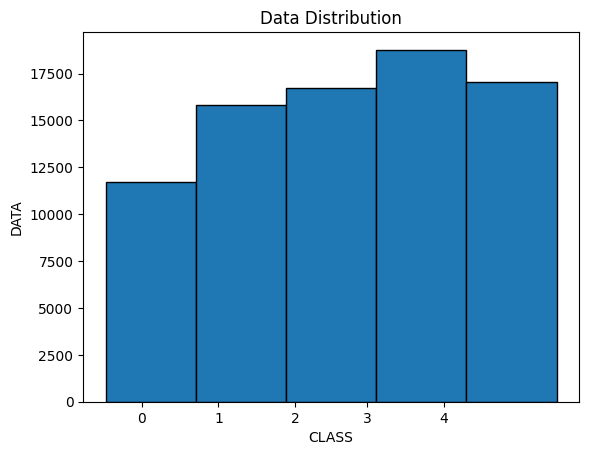

In [4]:
# keep only the columns we need, real imag and class
df = df[['real','imag','snr', 'best_coeffs_idx', 'powr','class']]

# convert class to numeric
print(type(df['class'][0]))
df['class'] = pd.to_numeric(df['class'])
print(type(df['class'][0]))

# check the distribution of the classes
print(df['class'].value_counts())
y = df['class'].values

# check the distribution of the classes

labels= ['0','1','2','3','4']
plt.hist(y, bins=5, edgecolor='black')# bins is the number of bins you want to divide the data into
plt.xticks([0.4, 1.25, 2.1, 2.9, 3.75], labels) # Set the x-axis ticks at the center of bins  
plt.xlabel('CLASS')
plt.ylabel('DATA')
plt.title('Data Distribution')

plt.show()
'''#use only for 486 features
# convert real and imaginary to list
df_real =  pd.DataFrame(df.real.to_list())
df_imag =  pd.DataFrame(df.imag.to_list())
df_snr =  pd.DataFrame(df.snr.to_list())
df_powr =  pd.DataFrame(df.powr.to_list())
df_best_coeffs_idx =  pd.DataFrame(df.best_coeffs_idx.to_list())'''

#use only for 18 features
# convert real and imaginary to list
df_real =  df.real.to_list()
df_imag =  df.imag.to_list()
df_snr =  df.snr.to_list()
df_powr =  df.powr.to_list()
df_best_coeffs_idx =  df.best_coeffs_idx.to_list()

In [ ]:
df_real_best =[]
real_line_values =[]
imag_line_values = []
df_imag_best=[]
cnt = 1
iter = 0

for line, real_indices in zip(df_real, df_best_coeffs_idx):
    real_indices = sorted(real_indices)

    for idx,value in zip(real_indices,line):
      
        while idx > cnt :
            cnt+=1
            if idx == cnt:
                break
            elif idx < len(line):
                value = line[idx-1]

        if idx==cnt:
            real_line_values.append(value)
            iter=iter+1

            if iter == 8:
                df_real_best.append(real_line_values)
                real_line_values = []
                iter = 0
                cnt=1
                break

cntIm=1 
iter = 0   
                    
for line, imag_indices in zip(df_imag,df_best_coeffs_idx):
    imag_indices = sorted(imag_indices)
    for idx,value in zip(imag_indices,line):
        while idx > cntIm :
            cntIm+=1
            if idx == cntIm:
                break
            elif idx < len(line):
                value = line[idx-1]
        if idx==cntIm:
            imag_line_values.append(value)
            iter=iter+1

            if iter == 8:
                df_imag_best.append(imag_line_values)
                imag_line_values = []
                iter = 0
                cntIm=1
                break

'''# Drop the last row
df_real = df_real[:-1]
df_imag = df_imag[:-1]
df_powr = df_powr[:-1]
df_snr = df_snr[:-1]
y = y[:-1]'''

In [ ]:
# convert real and imaginary to list
df_real = pd.DataFrame(df_real_best)
df_imag = pd.DataFrame(df_imag_best)
df_snr = pd.DataFrame(df_snr)
df_powr = pd.DataFrame(df_powr)


In [ ]:


print(df)
print(df_real)
print(df_imag)
print(df_snr)
print(df_powr)

# concat the real and imag dataframes 
df_final = pd.concat([df_real, df_imag, df_snr, df_powr, df['class']], axis=1)

print(df.head())
print(df_final)

print(df_final.shape)

# map the classes 1,2,3,4,5 to 1 
df_final['class'] = df_final['class'].map({0:0, 1:1, 2:1, 3:1, 4:1})

print(df_final['class'].value_counts())

In [1]:
# drop the samples with class 2 and define samples and labels
y = df_final['class'].values
X = df_final.drop('class', axis=1).values 

X = X[:-1]
y = y[:-1]

print(X.shape)
print(y.shape)
print(X)
print(y)

NameError: name 'df_final' is not defined

## Preprocessing Testing Dataset

In [ ]:
# keep only the columns we need, real imag and class
df_test = df_test[['real','imag','snr', 'best_coeffs_idx', 'powr','class']]

# convert class to numeric
print(type(df_test['class'][0]))
df_test['class'] = pd.to_numeric(df_test['class'])
print(type(df_test['class'][0]))

# check the distribution of the classes
print(df_test['class'].value_counts())
y_test = df_test['class'].values

# check the distribution of the classes

labels= ['0','1','2','3','4']
plt.hist(y_test, bins=5, edgecolor='black')# bins is the number of bins you want to divide the data into
plt.xticks([0.4, 1.25, 2.1, 2.9, 3.75], labels) # Set the x-axis ticks at the center of bins  
plt.xlabel('CLASS')
plt.ylabel('DATA')
plt.title('Testing Data Distribution')

plt.show()


#use only for 18 features
# convert real and imaginary to list
df_real_test =  df.real.to_list()
df_imag_test =  df.imag.to_list()
df_snr_test =  df.snr.to_list()
df_powr_test =  df.powr.to_list()
df_best_coeffs_idx_test =  df.best_coeffs_idx.to_list()

'''# convert real and imaginary to list
df_real_test = pd.DataFrame(df_test.real.to_list())
df_imag_test = pd.DataFrame(df_test.imag.to_list())
df_snr_test = pd.DataFrame(df_test.snr.to_list())
df_powr_test = pd.DataFrame(df_test.powr.to_list())
df_best_coeffs_idx_test = pd.DataFrame(df_test.best_coeffs_idx.to_list())'''

In [ ]:
df_real_best_test =[]
real_line_values_test =[]
imag_line_values_test = []
df_imag_best_test=[]
cnt = 1
iter = 0
i = 0

for line, real_indices in zip(df_real_test, df_best_coeffs_idx_test):
    real_indices = sorted(real_indices)

    for idx,value in zip(real_indices,line):
      
        while idx > cnt :
            cnt+=1
            if idx == cnt:
                break
            elif idx < len(line):
                value = line[idx-1]

        if idx==cnt:
            real_line_values_test.append(value)
            iter=iter+1

            if iter == 8:
                df_real_best_test.append(real_line_values_test)
                real_line_values_test = []
                iter = 0
                cnt=1
                break

cntIm=1 
iter = 0   
                    
for line, imag_indices in zip(df_imag_test,df_best_coeffs_idx_test):
    imag_indices = sorted(imag_indices)

    for idx,value in zip(imag_indices,line):
      
        while idx > cntIm :
            cntIm+=1
            if idx == cntIm:
                break
            elif idx < len(line):
                value = line[idx-1]

        if idx==cntIm:
            imag_line_values_test.append(value)
            iter=iter+1

            if iter == 8:
                df_imag_best_test.append(imag_line_values_test)
                imag_line_values_test = []
                iter = 0
                cntIm=1
                break


In [ ]:
# convert real and imaginary to list
df_real_test = pd.DataFrame(df_real_best_test)
df_imag_test = pd.DataFrame(df_imag_best_test)
df_snr_test = pd.DataFrame(df_snr_test)
df_powr_test = pd.DataFrame(df_powr_test)


In [ ]:

print(df_test)
print(df_real_test)
print(df_imag_test)
print(df_snr_test)
print(df_powr_test)

# concat the real and imag dataframes 
df_final_test = pd.concat([df_real_test, df_imag_test, df_snr_test, df_powr_test, df_test['class']], axis=1)

print(df_test.head())
print(df_final_test)

print(df_final_test.shape)

# map the classes 1,2,3,4,5 to 1 
df_final_test['class'] = df_final_test['class'].map({0:0, 1:0, 2:1, 3:1, 4:2})

print(df_final_test['class'].value_counts())

In [ ]:
# drop the samples with class 2 and define samples and labels
y_test = df_final_test['class'].values
X_test = df_final_test.drop('class', axis=1).values 

'''y_test = y_test[:-2]
X_test = X_test[:-2]'''

print(X_test.shape)
print(y_test.shape)
print(X_test)
print(y_test)

## Gaussian Naive Bayes

In [ ]:
# create classifier
gnb = GaussianNB()

# stratified k-fold cross validation
skf = StratifiedKFold(n_splits=4)

# lists to store accuracy and confusion matrix for each fold
acc_list = []
cm_list = []

# create scaler
scaler = StandardScaler()

# iterate over folds
for train_index, test_index in skf.split(X, y):
    # split data into train and test set
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # fit and transform the training data
    X_train = scaler.fit_transform(X_train)
    
    # transform the testing data
    X_test = scaler.transform(X_test)

    # train classifier
    gnb.fit(X_train, y_train)

    # predict labels for test set
    y_pred = gnb.predict(X_test)

    # calculate accuracy and confusion matrix

    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    # append accuracy and confusion matrix to lists
    acc_list.append(acc)
    cm_list.append(cm)

# print mean accuracy and mean confusion matrix
print(np.mean(acc_list))
print(np.mean(cm_list, axis=0))

## XGBoost

In [ ]:
# create classifier
xgb = xgboost.XGBClassifier()

# stratified k-fold cross validation
skf = StratifiedKFold(n_splits=3)

# lists to store accuracy and confusion matrix for each fold
acc_list = []
cm_list = []

# create scaler
scaler = StandardScaler()

# iterate over folds
for train_index, test_index in skf.split(X, y):
    # split data into train and test set
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # fit and transform the training data
    X_train = scaler.fit_transform(X_train)
    
    # transform the testing data
    X_test = scaler.transform(X_test)

    # train classifier
    xgb.fit(X_train, y_train)

    # predict labels for test set
    y_pred = xgb.predict(X_test)

    # calculate accuracy and confusion matrix

    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    # append accuracy and confusion matrix to lists
    acc_list.append(acc)
    cm_list.append(cm)

# print mean accuracy and mean confusion matrix
print(np.mean(acc_list))
print(np.mean(cm_list, axis=0))

## LightGBM

In [ ]:
# assume we have a dataset X with labels y
X_train, X_test1, y_train, y_test1 = train_test_split(X, y, test_size=0.2, random_state=42)
# use variance threshold to remove features with low variances and scale the data
variance_threshold = VarianceThreshold(threshold=np.median(np.var(X_train, axis=0)))
scaler = StandardScaler()
# only fit train data and then transform all
for transformer in (scaler, variance_threshold):
    X_train = transformer.fit_transform(X_train)
    X_test1 = transformer.transform(X_test1)

# create a LightGBM classifier
clf = lgb.LGBMClassifier()

# define search parameters
param_dist = {
    'num_leaves': list(range(30, 50)),
    'min_data_in_leaf': [30, 40],
    'max_depth': [int(x) for x in np.linspace(10, 50, num = 5)],
    'learning_rate': [0.01, 0.05, 0.1],
    'min_child_samples': list(range(100, 200, 20)),
    'boosting': ['gbdt'],'objective': ['multiclass'],'metric': ['multi_logloss'],'num_class': [5],  
    'feature_fraction': [0.6, 0.8],'bagging_fraction': [0.8, 1.0],
    'bagging_freq': list(range(20, 30)),
    'subsample': [0.6, 0.8, 1.0], 'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 1],'reg_lambda': [1, 2],
}

# create randomized search 5-fold cross validation and 100 iterations
clf_cv = RandomizedSearchCV(clf, param_distributions = param_dist, n_iter = 25, scoring = 'f1_macro', n_jobs = -1, cv = 2, verbose = 3)  # Use 'f1_macro' for multiclass problems
# fit model
clf_cv.fit(X_train, y_train)
# view best hyperparameters
print('Best Score:', clf_cv.best_score_)
print('Best Parameters:', clf_cv.best_params_)

# use the best estimator to make predictions
y_pred = clf_cv.best_estimator_.predict(X_test1)

# calculate accuracy and confusion matrix
acc_lgbm = accuracy_score(y_test1, y_pred)
cm = confusion_matrix(y_test1, y_pred)
# print accuracy and confusion matrix
print(acc_lgbm)
print(cm)

## Feedforward Neural Network

### FNN Preprocessing

In [ ]:
# first split the data into training (80%) and test (20%) set
X_train, X_test1, y_train, y_test1 = train_test_split(X, y, test_size=0.2)

# then split the training set further into training (80%) and validation (20%) set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

# Drop rows with missing values
#df.dropna(inplace=True)

# Apply SMOTE
#smote = SMOTE(random_state=42)
#X_train, y_train = smote.fit_resample(X_train, y_train)
#X_val, y_val = smote.fit_resample(X_val, y_val)
#X_test, y_test = smote.fit_resample(X_test, y_test)

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_val = imputer.transform(X_val)
X_test1 = imputer.transform(X_test1)
# use variance threshold to remove features with low variances and scale the data
variance_threshold = VarianceThreshold(threshold=np.median(np.var(X_train, axis=0)))
scaler = StandardScaler()

# only fit train data and then transform all
for transformer in (scaler, variance_threshold):
    X_train = transformer.fit_transform(X_train)
    X_val = transformer.transform(X_val)
    X_test1 = transformer.transform(X_test1)

# Verify the resampled dataset
print("Before resampling:")
print(pd.value_counts(y_train))
print(pd.value_counts(y_val))
print(pd.value_counts(y_test1))
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test1.shape)

### Train and Evaluate

In [ ]:

input_shape = (X_train.shape[1],)
output_shape = len(np.unique(y_train))


# create the model 
model = Sequential([
    Dense(256, input_shape=input_shape, activation='relu'),
    #BatchNormalization(),
    Dropout(0.4),
    Dense(128, activation='relu'),
    #BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    #BatchNormalization(),
    Dropout(0.2),
    Dense(output_shape, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)

# fit the model using the training and validation data
history = model.fit(X_train, y_train, epochs=500, validation_data=(X_val, y_val), batch_size=512, callbacks=[early_stopping])

# evaluate the model using the test data
y_pred = np.argmax(model.predict(X_test1), axis=-1)
test_loss, test_accuracy = model.evaluate(X_test1, y_test1)
print(f"Test accuracy: {test_accuracy}")

# retrieve the training and validation loss and accuracy
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']


### FNN Plots and Cofusion Matrix

In [ ]:

# plot the training and validation loss
plt.figure(figsize=(8, 4))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# plot the training and validation accuracy
plt.figure(figsize=(8, 4))
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


# generate the confusion matrix
cm = confusion_matrix(y_test1.astype(int), y_pred.astype(int))

# plot the confusion matrix using Matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = np.unique(y_test)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show() 


# Histogramms

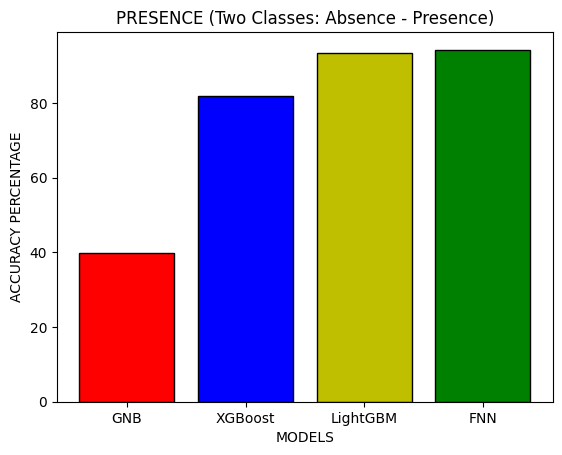

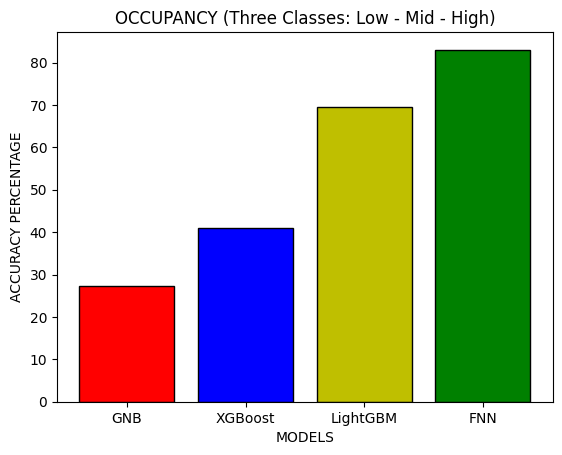

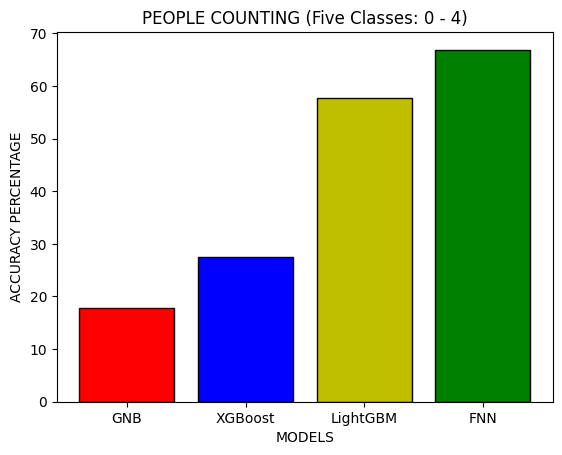

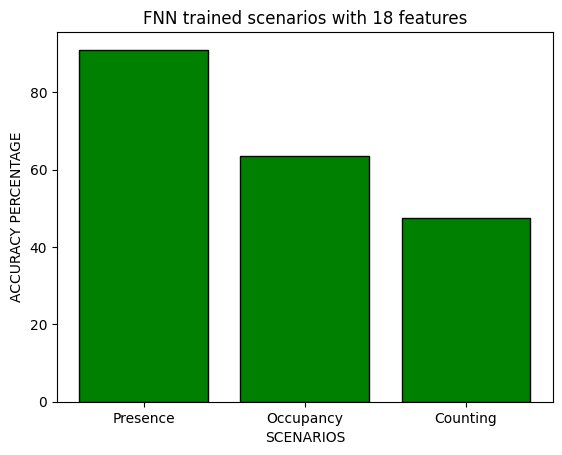

In [3]:
data = [39.88, 82.03, 93.50, 94.30]
labels= ['GNB','XGBoost','LightGBM','FNN']
plt.bar(labels, data, edgecolor= "black", color=['r', 'b', 'y', 'g'])
plt.xlabel('MODELS')
plt.ylabel('ACCURACY PERCENTAGE')
plt.title('PRESENCE (Two Classes: Absence - Presence)')


plt.show()

data = [27.18, 40.97, 69.43, 83.03]
labels= ['GNB','XGBoost','LightGBM','FNN']
plt.bar(labels, data, edgecolor= "black", color=['r', 'b', 'y', 'g'])
plt.xlabel('MODELS')
plt.ylabel('ACCURACY PERCENTAGE')
plt.title('OCCUPANCY (Three Classes: Low - Mid - High)')


plt.show()

data = [17.80, 27.57, 57.70, 66.88]
labels= ['GNB','XGBoost','LightGBM','FNN']
plt.bar(labels, data, edgecolor= "black", color=['r', 'b', 'y', 'g'])
plt.xlabel('MODELS')
plt.ylabel('ACCURACY PERCENTAGE')
plt.title('PEOPLE COUNTING (Five Classes: 0 - 4)')


plt.show()

data = [90.98, 63.48, 47.37]
labels= ['Presence','Occupancy','Counting']
plt.bar(labels, data, edgecolor= "black", color=['g'])
plt.xlabel('SCENARIOS')
plt.ylabel('ACCURACY PERCENTAGE')
plt.title('FNN trained scenarios with 18 features')

plt.show()